<a href="https://colab.research.google.com/github/sidharkal/Wheat-Detection-with-yolo5/blob/main/Global_Wheat_Detection_Object_detection_with_YOLO_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Necessary Imports
import torch
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.auto import tqdm
import shutil as sh

### Clone YOLOv5 GitHub repository

In [2]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15532, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 15532 (delta 51), reused 118 (delta 43), pack-reused 15393
Receiving objects: 100% (15532/15532), 14.59 MiB | 1.34 MiB/s, done.
Resolving deltas: 100% (10579/10579), done.


In [3]:
!mv yolov5/* ./

### Install the requirements

In [4]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [5]:
!pip install -q kaggle

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sidharkal","key":"80b08e48a736911d51990317d2e3a6b9"}'}

In [7]:
!ls -lha kaggle.json
!pip install -q kaggle  # installing the kaggle package
!mkdir -p ~/.kaggle    # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory

#3. giving rw access (if 401-nathorized)

!chmod 600 ~/.kaggle/kaggle.json
# Else retry with fresh API token

#4. Sanity check if able to access kaggle
!kaggle datasets list

-rw-r--r-- 1 root root 65 Apr 17 18:17 kaggle.json
/content
ref                                                               title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                             Spotify and Youtube                                 9MB  2023-03-20 15:43:25           7323        277  1.0              
ppb00x/country-gdp                                                Country_GDP                                         7KB  2023-04-07 06:47:36            802         29  1.0              
erdemtaha/cancer-data                                             Cancer Data                                        49KB  2023-03-22 07:57:00           2914         72  1.0              


# Download the Dataset

In [8]:
!kaggle competitions download -c global-wheat-detection

 99% 604M/607M [00:20<00:00, 36.9MB/s]
100% 607M/607M [00:20<00:00, 30.6MB/s]


In [9]:
!unzip global-wheat-detection.zip -d wheat_data

Archive:  global-wheat-detection.zip
  inflating: wheat_data/sample_submission.csv  
  inflating: wheat_data/test/2fd875eaa.jpg  
  inflating: wheat_data/test/348a992bb.jpg  
  inflating: wheat_data/test/51b3e36ab.jpg  
  inflating: wheat_data/test/51f1be19e.jpg  
  inflating: wheat_data/test/53f253011.jpg  
  inflating: wheat_data/test/796707dd7.jpg  
  inflating: wheat_data/test/aac893a91.jpg  
  inflating: wheat_data/test/cb8d261a3.jpg  
  inflating: wheat_data/test/cc3532ff6.jpg  
  inflating: wheat_data/test/f5a1f0358.jpg  
  inflating: wheat_data/train.csv    
  inflating: wheat_data/train/00333207f.jpg  
  inflating: wheat_data/train/005b0d8bb.jpg  
  inflating: wheat_data/train/006a994f7.jpg  
  inflating: wheat_data/train/00764ad5d.jpg  
  inflating: wheat_data/train/00b5c6764.jpg  
  inflating: wheat_data/train/00b5fefed.jpg  
  inflating: wheat_data/train/00b70a919.jpg  
  inflating: wheat_data/train/00e903abe.jpg  
  inflating: wheat_data/train/00ea5e5ee.jpg  
  inflating: 

# Read The Dataset

In [10]:
data = pd.read_csv('/content/wheat_data/train.csv')
data.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [11]:
data.shape

(147793, 5)

In [12]:
bboxs = np.stack(data['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
bboxs

array([[834., 222.,  56.,  36.],
       [226., 548., 130.,  58.],
       [377., 504.,  74., 160.],
       ...,
       [134., 228., 141.,  71.],
       [430.,  13., 184.,  79.],
       [875., 740.,  94.,  61.]])

In [13]:
for i, column in enumerate(['x', 'y', 'w', 'h']):
    data[column] = bboxs[:,i]

data.drop(columns=['bbox'], inplace=True)
data['x_center'] = data['x'] + data['w']/2
data['y_center'] = data['y'] + data['h']/2
data['classes'] = 0


data = data[['image_id','x', 'y', 'w', 'h','x_center','y_center','classes']]
data.head()

image_id      x      y      w      h  x_center  y_center  classes
0  b6ab77fd7  834.0  222.0   56.0   36.0     862.0     240.0        0
1  b6ab77fd7  226.0  548.0  130.0   58.0     291.0     577.0        0
2  b6ab77fd7  377.0  504.0   74.0  160.0     414.0     584.0        0
3  b6ab77fd7  834.0   95.0  109.0  107.0     888.5     148.5        0
4  b6ab77fd7   26.0  144.0  124.0  117.0      88.0     202.5        0

In [14]:
index = list(set(data.image_id))
len(index)

3373

In [15]:
source = 'train'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(data.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('convertor/fold{}/labels/'.format(fold)+path2save)
            with open('convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row/1024
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/content/wheat_data/{}/{}.jpg".format(source,name),'convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

  0%|          | 0/3373 [00:00<?, ?it/s]

In [16]:
%%writefile ./convertor/wheat0.yaml

# COCO 2017 dataset http://cocodataset.org - first 128 training images
# Download command:  python -c "from yolov5.utils.google_utils import gdrive_download; gdrive_download('1n_oKgR81BJtqk75b00eAjdv03qVCQn2f','coco128.zip')"
# Train command: python train.py --data ./data/coco128.yaml
# Dataset should be placed next to yolov5 folder:
#   /parent_folder
#     /coco128
#     /yolov5


# train and val datasets (image directory or *.txt file with image paths)
train: ./convertor/fold0/images/train2017/
val: ./convertor/fold0/images/val2017/

# number of classes
nc: 1

# class names
names: ['wheat']

Writing ./convertor/wheat0.yaml


In [17]:
%%writefile ./convertor/yolov5x.yaml



# parameters
nc: 1  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple

# parameters
nc: 1  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple

# anchors
anchors:
  - [116,90, 156,198, 373,326]  # P5/32
  - [30,61, 62,45, 59,119]  # P4/16
  - [10,13, 16,30, 33,23]  # P3/8

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
  ]

# YOLOv5 head
head:
  [[-1, 3, BottleneckCSP, [1024, False]],  # 9

   [-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],
   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1]],  # 18 (P3/8-small)

   [-2, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],
   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1]],  # 22 (P4/16-medium)

   [-2, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],
   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1]],  # 26 (P5/32-large)

   [[], 1, Detect, [nc, anchors]],  # Detect(P5, P4, P3)
  ]

Writing ./convertor/yolov5x.yaml


In [18]:
!python /content/train.py --img 1024 --batch 8 --epochs 5 --data /content/convertor/wheat0.yaml --name yolov5x_fold0 

train: weights=yolov5s.pt, cfg=, data=/content/convertor/wheat0.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=8, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5x_fold0, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
requirements: /requirements.txt not found, check failed.
YOLOv5 🚀 2023-4-17 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls

In [19]:
# get a list of experiments
exp_list = os.listdir('/content/runs/train')

# Get the latest exp.

exp = exp_list[-1]

exp

'yolov5x_fold0'

In [20]:
!python /content/detect.py --weights runs/train/yolov5x_fold0/weights/best.pt --img 1024  --source /content/convertor/fold0/images/val2017 

detect: weights=['runs/train/yolov5x_fold0/weights/best.pt'], source=/content/convertor/fold0/images/val2017, data=data/coco128.yaml, imgsz=[1024, 1024], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /requirements.txt not found, check failed.
YOLOv5 🚀 2023-4-17 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/674 /content/convertor/fold0/images/val2017/00764ad5d.jpg: 1024x1024 39 wheats, 22.7ms
image 2/674 /content/convertor/fold0/images/val2017/00b5fefed.jpg: 1024x1024 22 wheats, 22.7ms
image 3/674 /content/convertor/fold0/images/val2017/00ea5e5ee.jpg: 1024x1024

In [21]:
os.listdir('/content/runs/train')

['yolov5x_fold0']

In [22]:
# Display the contents of the "exp" folder
os.listdir(f'/content/runs/train/{exp}')

['train_batch1.jpg',
 'val_batch0_labels.jpg',
 'train_batch2.jpg',
 'events.out.tfevents.1681755535.518858b8ea1a.1432.0',
 'F1_curve.png',
 'PR_curve.png',
 'hyp.yaml',
 'labels_correlogram.jpg',
 'confusion_matrix.png',
 'R_curve.png',
 'results.png',
 'train_batch0.jpg',
 'weights',
 'results.csv',
 'opt.yaml',
 'val_batch1_labels.jpg',
 'val_batch2_pred.jpg',
 'labels.jpg',
 'val_batch0_pred.jpg',
 'val_batch2_labels.jpg',
 'P_curve.png',
 'val_batch1_pred.jpg']

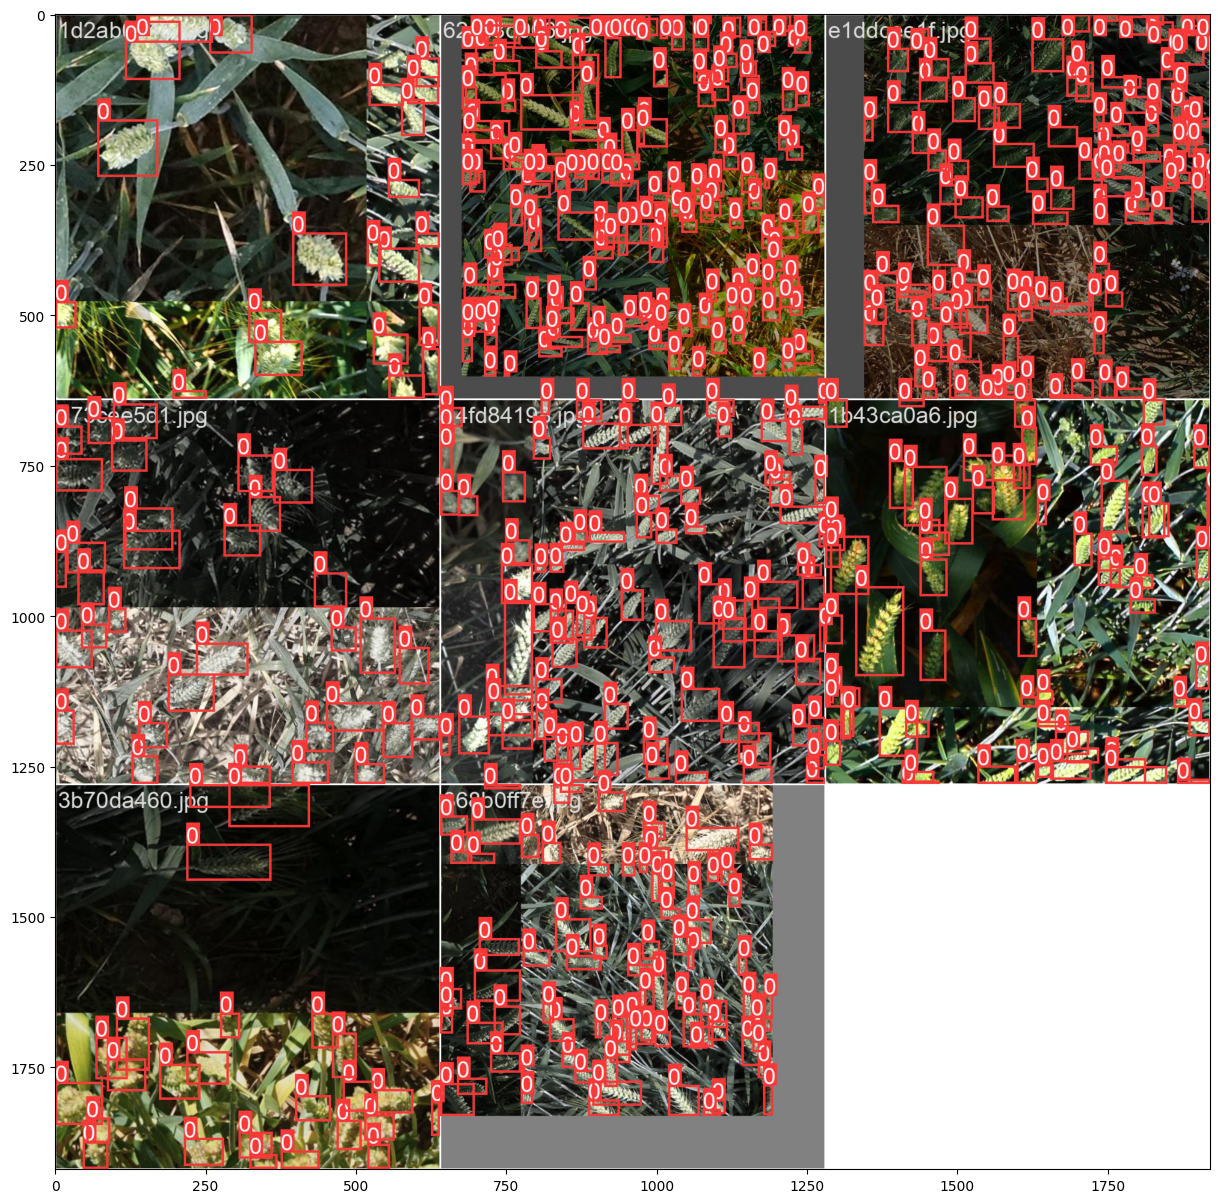

In [23]:
# One mosaic batch of train images with labels
plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{exp}/train_batch2.jpg'))

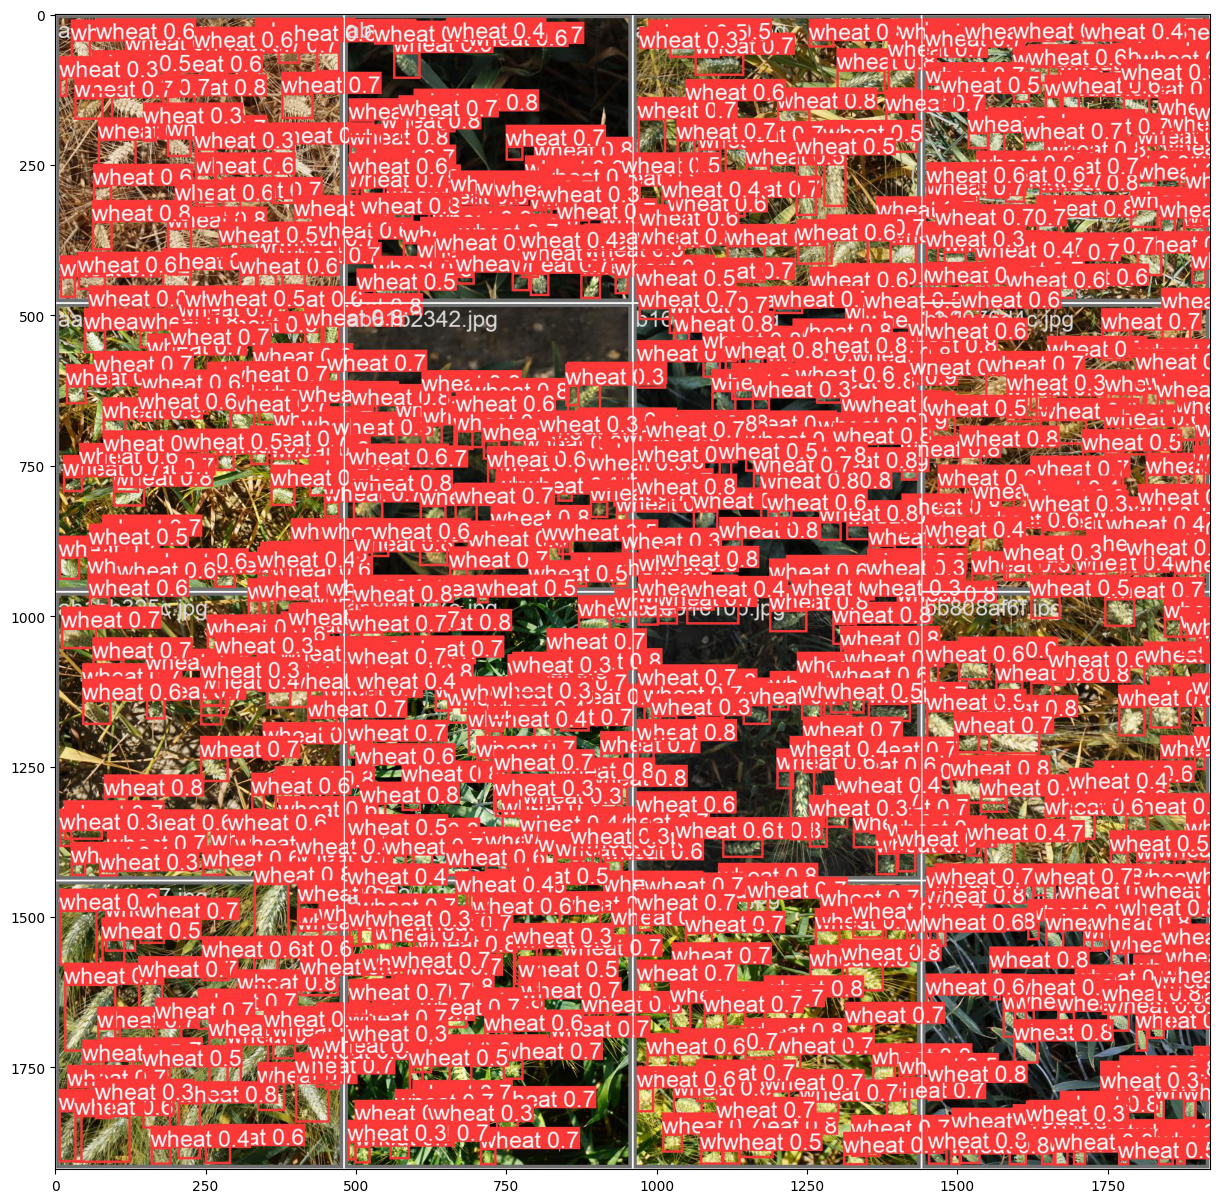

In [24]:
# One batch of val images with true labels
plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{exp}/val_batch2_pred.jpg'))